In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 4.3MB/s 


In [ ]:
import pandas as pd
pd.options.display.max_rows=999999
import string
import numpy as np

import os
import re

from datetime import datetime
import time
import pytz

import warnings
warnings.simplefilter("ignore")

import joblib
from datetime import datetime
import time
import pytz

tz = pytz.timezone('Asia/Saigon')
now = datetime.now(tz)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from keras.optimizers import SGD


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read dataset

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Deep Learning/baseline/Tokenize02/Tokenize02_dataclean.csv')


### Gom từ haha


In [ ]:
df.columns = df.columns.astype('str')
df.dropna(inplace=True)
df.head()


,original_signed,vn_token,unsigned
0,đó là chủ đề sắc màu âm nhạc tháng sẽ diễn ra ...,đó là chủ_đề sắc_màu âm_nhạc tháng sẽ diễn ra ...,do la chu_de sac_mau am_nhac thang se dien ra ...
1,tại câu lạc bộ nguyễn du,tại câu_lạc_bộ nguyễn_du,tai cau_lac_bo nguyen_du
2,tham gia chương trình lần này các ca sĩ hồ ngọ...,tham_gia chương_trình lần này các ca_sĩ hồ ngọ...,tham_gia chuong_trinh lan nay cac ca_si ho ngo...
3,giống như được hầu hết báo chí ở việt nam nhắc...,giống như được hầu_hết báo_chí ở việt_nam nhắc...,giong nhu duoc hau_het bao_chi o viet_nam nhac...
4,nhưng đối với người yêu nhạc chịu khó chút xíu...,nhưng đối_với người_yêu nhạc chịu_khó chút_xíu...,nhung doi_voi nguoi_yeu nhac chiu_kho chut_xiu...


# Create vocabulary dictionary

In [ ]:
train_sentence = df.iloc[:500000,2]
train_target = df.iloc[:500000,1]

train_tokenizer = Tokenizer(filters = '')
train_tokenizer.fit_on_texts(train_sentence)

label_tokenizer = Tokenizer(filters = '')
label_tokenizer.fit_on_texts(train_target)

train_vocal_size = len(train_tokenizer.word_index) + 1
label_vocal_size = len(label_tokenizer.word_index) + 1

print(f'Train vocabulary size: {train_vocal_size}')
print(f'Label vocabulary size: {label_vocal_size}')

Train vocabulary size: 27692
Label vocabulary size: 34431


# Preprocessing data

In [ ]:
def PreData(train_vocab,label_vocab,sentence,target,df,MaxLen = 0,name = 'Train'):
  sequence = train_tokenizer.texts_to_sequences(sentence)
  label = label_tokenizer.texts_to_sequences(target)

  if name == 'Train':
    padded_sequence = pad_sequences(sequence, padding = "post") 
    padded_label =  pad_sequences(label, padding = "post") 

    MaxLen = len(padded_sequence[0])
    print(f'Maximum length train sentence: {MaxLen}')
  else:
    padded_sequence = pad_sequences(sequence,maxlen = MaxLen,truncating = 'post', padding = "post") 
    padded_label =  pad_sequences(label,maxlen = MaxLen,truncating = 'post', padding = "post")
  
  #padded_label = np.reshape(padded_label,(*padded_label.shape, 1))
  pad_seq = pad_sequences(padded_sequence, padded_label.shape[1], padding = "post")
  pad_seq = pad_seq.reshape((-1, padded_label.shape[-2]))
  
  return MaxLen, padded_label , padded_sequence, pad_seq.shape


In [ ]:
train_sentence_length, padded_train_label, train, input_shape = PreData(train_tokenizer,label_tokenizer,train_sentence,train_target,df)

Maximum length train sentence: 230


In [ ]:
test_sentence = df.iloc[500000:,2]
test_target = df.iloc[500000:,1]

test_sentence.index = range(0,test_sentence.shape[0])
test_target.index = range(0,test_target.shape[0])

In [ ]:
_, padded_test_label, test, __ = PreData(train_tokenizer,label_tokenizer,test_sentence,test_target,df,train_sentence_length,'Test')

In [ ]:
embedding_dim = 256
learning_rate = 0.003

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, TimeDistributed,Dropout,GRU,Bidirectional,RepeatVector,LSTM, Conv2D, GlobalMaxPooling2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def Simple_RNN(input_shape, label_vocal_size):
   model = Sequential()
   model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
   model.add(TimeDistributed(Dense(1024, activation='relu')))
   model.add(Dropout(0.5))
   model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax'))) 
   return model

In [ ]:
input_shape

(230, 500000)

In [ ]:
def Embed(input_shape,embedding_dim,train_vocal_size,label_vocal_size):
  model = Sequential()
  model.add(Embedding(train_vocal_size,embedding_dim, input_length = input_shape[1], input_shape=input_shape[1:] ))
  model.add(GRU(128,return_sequences=True))
  model.add(TimeDistributed(Dense(512, activation='relu')))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax'))) 

  return model

In [ ]:
def Embedding_Bidirectional_GRU_RELU(input_shape,embedding_dim,train_vocal_size,label_vocal_size):
  model = Sequential()
  model.add(Embedding(train_vocal_size,embedding_dim, input_length = input_shape[1], input_shape=input_shape[1:] ))
  model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
  model.add(TimeDistributed(Dense(1024, activation='relu')))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax'))) 

  return model

In [ ]:
def Embedding_Bidirectional_GRU_TANH(input_shape,embedding_dim,train_vocal_size,label_vocal_size):
  model = Sequential()
  model.add(Embedding(train_vocal_size,embedding_dim, input_length = input_shape[1], input_shape=input_shape[1:] ))
  model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
  model.add(TimeDistributed(Dense(1024, activation='tanh')))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax'))) 

  return model

In [ ]:
def Embedding_Bidirectional_LSTM_RELU(input_shape,embedding_dim,train_vocal_size,label_vocal_size):
  model = Sequential()
  model.add(Embedding(train_vocal_size,embedding_dim, input_length = input_shape[1], input_shape=input_shape[1:] ))
  model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape[1:]))
  model.add(TimeDistributed(Dense(1024, activation='relu')))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax'))) 

  return model

In [ ]:
def Embedding_Bidirectional_LSTM_TANH(input_shape,embedding_dim,train_vocal_size,label_vocal_size):
  model = Sequential()
  model.add(Embedding(train_vocal_size,embedding_dim, input_length = input_shape[1], input_shape=input_shape[1:] ))
  model.add(Bidirectional(LSTM(128, return_sequences=True)),input_shape=input_shape[1:])
  model.add(TimeDistributed(Dense(1024, activation='tanh')))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax'))) 

  return model

In [ ]:
def Embedding_Encoder_Decoder(input_shape,embedding_dim,train_vocal_size,label_vocal_size):
    model = Sequential()
    model.add(Embedding(train_vocal_size,embedding_dim, input_length = input_shape[1], input_shape=input_shape[1:] ))
  # Encoder
    model.add(GRU(128,input_shape=input_shape[1:], go_backwards=True))
    model.add(RepeatVector(input_shape[1]))
  # Decoder
    model.add(GRU(128, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(label_vocal_size, activation='softmax')))

    return model

In [ ]:
enter = "4"
#enter = int(input())
print('0: Simple RNN model\n1: Embedding model\n2: Embedding_Bidirectional_GRU model\n 3:Embedding_Encoder_Decoder model\n 4: Embedding_Bidirectional_LSTM model')
if int(enter) == 0:
  model = Simple_RNN(input_shape, label_vocal_size)
elif int(enter) == 1:
  model = Embed(input_shape,embedding_dim,train_vocal_size,label_vocal_size)
elif int(enter) == 2:
  model = Embedding_Bidirectional_GRU_RELU(input_shape,embedding_dim,train_vocal_size,label_vocal_size)
elif int(enter) == 3:
  model = Embedding_Bidirectional_GRU_TANH(input_shape,embedding_dim,train_vocal_size,label_vocal_size)
elif int(enter) == 5:
  model = Embedding_Encoder_Decoder(input_shape,embedding_dim,train_vocal_size,label_vocal_size)
elif int(enter) == 4:
  model = Embedding_Bidirectional_LSTM_RELU(input_shape,embedding_dim,train_vocal_size,label_vocal_size)


0: Simple RNN model
1: Embedding model
2: Embedding_Bidirectional_GRU model
 3:Embedding_Encoder_Decoder model
 4: Embedding_Bidirectional_LSTM model


In [ ]:
model.compile(loss = sparse_categorical_crossentropy, optimizer= Adam(learning_rate), metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500000, 256)       7089152   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500000, 256)       394240    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 500000, 1024)      263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500000, 1024)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 500000, 34431)     35291775  
Total params: 43,038,335
Trainable params: 43,038,335
Non-trainable params: 0
_________________________________________________________________


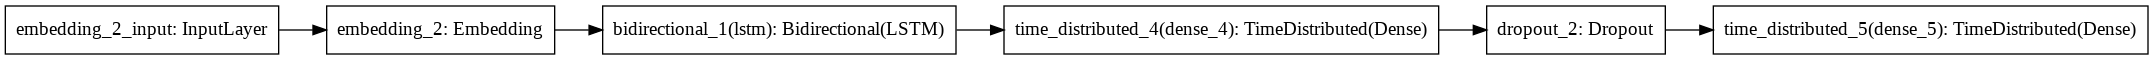

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot_params.png', show_shapes=False, show_layer_names=True, rankdir="LR",)

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Deep Learning/baseline/Tokenize02/History/15:00:31_04:01:21EMBEDED_model.h5')

In [ ]:
from keras import backend as K
hist = model.fit(train,padded_train_label,batch_size = 50 , epochs = 1, validation_data = (test , padded_test_label))

10000/10000 [==============================] - 4682s 467ms/step - loss: 0.0311 - acc: 0.9926 - val_loss: 0.0296 - val_acc: 0.9933


In [ ]:
cd /content/drive/MyDrive/Deep Learning/baseline/Tokenize02

/content/drive/.shortcut-targets-by-id/1W6Ppcd24tbrwLTD4MM9gT3p2iLDppXUc/Deep Learning/baseline/Tokenize02


In [ ]:
current_time = now.strftime("%H:%M:%S_%d:%m:%y")
print("Current Dateime =", current_time)

data = {'loss': hist.history['loss'], 'accuracy': hist.history['acc'], 'val_loss': hist.history['val_loss'], 'val_acc': hist.history['val_acc']}
Csv = pd.DataFrame(data)
model.save(f'./{current_time}EMBEDED_model.h5')
Csv.to_csv(f'./em_history.csv', index=0)

Current Dateime = 08:23:02_05:01:21


In [ ]:
hist = model.fit(train,padded_train_label, batch_size = 50, epochs = 2, validation_data = (test , padded_test_label))

Epoch 1/2
10000/10000 [==============================] - 4567s 457ms/step - loss: 0.0311 - acc: 0.9926 - val_loss: 0.0295 - val_acc: 0.9933
Epoch 2/2
10000/10000 [==============================] - 4570s 457ms/step - loss: 0.0300 - acc: 0.9927 - val_loss: 0.0290 - val_acc: 0.9934


In [ ]:
current_time = now.strftime("%H:%M:%S_%d:%m:%y")
print("Current Dateime =", current_time)

data = {'loss': hist.history['loss'], 'accuracy': hist.history['acc'], 'val_loss': hist.history['val_loss'], 'val_acc': hist.history['val_acc']}
Csv = pd.DataFrame(data)
model.save(f'./{current_time}EMBEDED_model.h5')
Csv.to_csv(f'./em_history.csv', index=0, header = False,mode = 'a')

Current Dateime = 19:45:52_03:01:21


NameError: ignored

In [ ]:

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''
    List = []
    for prediction in np.argmax(logits,1):
      if prediction != 0:
        List.append(index_to_words[prediction])
      else:
        pass
    return List

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
A = []
B = []
for i in range(len(test)):
  y_pred1 = model.predict(test[i:i+1])[0]
  
  pre_text = logits_to_text(y_pred1,label_tokenizer)
  true_text = [test_target[i].split(' ')]
  A.append(pre_text)
  B.append(true_text)
corpus_bleu(B,A,weight = (1,0,0,0))

In [ ]:
test_sentence = df.iloc[500000:500500,2]
test_target = df.iloc[500000:500500,1]

test_sentence.index = range(0,test_sentence.shape[0])
test_target.index = range(0,test_target.shape[0])

In [ ]:
_, padded_test_label, test, __ = PreData(train_tokenizer,label_tokenizer,test_sentence,test_target,df,train_sentence_length,'Test')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
A = []
B = []
for i in range(len(test)):
  y_pred1 = model.predict(test[i:i+1])[0]
  
  pre_text = logits_to_text(y_pred1,label_tokenizer)
  true_text = [test_target[i].split(' ')]
  A.append(pre_text)
  B.append(true_text)
corpus_bleu(B,A)

0.8120644532181187